## Packages

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1. Raw Data

In [3]:
df = pd.read_csv('BTC-USD.csv')

In [4]:
df['change'] = (df['Close']-df['Open'])/df['Open'] 
df.head()

,Date,Open,High,Low,Close,Volume,change
0,2019-03-31,4105.456055,4113.023438,4094.100830,4105.404297,9.045122e+09,-0.000013
1,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,1.015779e+10,0.012866
2,2019-04-02,4156.919434,4905.954590,4155.316895,4879.877930,2.131505e+10,0.173917
3,2019-04-03,4879.958008,5307.003418,4876.621094,4973.021973,2.289989e+10,0.019071
4,2019-04-04,4971.307617,5063.159668,4836.793945,4922.798828,1.825181e+10,-0.009758


In [5]:
df.columns = ['date', 'close', 'open', 'high', 'low', 'vol', 'change']

## 2. Data preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1827 non-null   object 
 1   close   1827 non-null   float64
 2   open    1827 non-null   float64
 3   high    1827 non-null   float64
 4   low     1827 non-null   float64
 5   vol     1827 non-null   float64
 6   change  1827 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


In [7]:
df.index = pd.to_datetime(df['date'])

In [8]:
df.drop(["date"], axis=1, inplace=True)

In [9]:
# This step is to plot the comparison between real value and predicted one
df_diff = df.diff()
mask_test = (df_diff.index  >= "2019-12-01") & (df_diff.index < "2020-01-01")  # December 2019 for testing
df_test_plot = df_diff.loc[mask_test].copy()

### 2-1. Feature Engineering: Minmax scaling


In [10]:
scaler = MinMaxScaler()

columns_to_scale = ['close', 'open', 'high', 'low', 'vol', 'change']

scaled_data = scaler.fit_transform(df[columns_to_scale])

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)

In [11]:
# Generate dataset function
def generate_dataset(df, seq_len):
    X_list, y_list = [], []
    for i in range(len(df) - seq_len):
        X_list.append(df.iloc[i:(i+seq_len), :].values)
        y_list.append(df["close"].iloc[i + seq_len])
    return np.array(X_list), np.array(y_list)

In [12]:
# # For LSTM only !!!
# LAG = 3 # Example: Use the past # days to predict the next day
# # Prepare training and test datasets
# X_train, y_train = generate_dataset(df_train, LAG)
# X_test, y_test = generate_dataset(pd.concat((df_train.iloc[-LAG:], df_test)), LAG)
# X_train.shape

In [13]:
# data for MLP
X = scaled_df.drop('close',axis=1)
y = scaled_df['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4012)

In [14]:
X_train.shape

(1461, 5)

### Model 1 (128 ReLU, BN, 64 ReLU)

In [15]:
tf.keras.utils.set_random_seed(4012)
model = Sequential()
model.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization(axis=-1, epsilon=1e-8))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [16]:
# Define early stopping criteria
# early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
model.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 0.1653 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0281
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.0188
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.0160
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.0119
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0115
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0111
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0111
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0119
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.0138
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.0136
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.0161
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0151
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0164
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step 

In [17]:
predicted_prices = model.predict(X_test)
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, predicted_prices)
mse_value

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(), dtype=float32, numpy=2.1608496>

In [18]:
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped[:, 0] = predicted_prices[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale = scaler.inverse_transform(predicted_prices_reshaped)
predicted_closing_prices = predicted_prices_original_scale[:, 0]
predicted_closing_prices

array([ 1.75030989e+04,  5.51105255e+04,  8.23006267e+03,  4.66169068e+04,
        4.53675062e+03,  5.11029185e+04,  4.69329202e+04,  5.33176313e+04,
        6.32138995e+04,  5.41186178e+03,  6.11364184e+03,  4.20010314e+04,
        5.74225744e+04,  4.59389541e+04,  6.27808973e+03,  6.71902533e+04,
        2.44043786e+04,  1.69468378e+04,  4.37993820e+03,  2.70143353e+04,
        5.21915855e+04,  1.91233773e+04,  3.10161702e+04,  2.48988826e+04,
        1.96169286e+04,  5.22783444e+03,  5.00358023e+04,  5.13144699e+03,
        2.38044271e+04,  3.40785284e+04,  8.16541295e+03,  2.52178027e+04,
        4.34826265e+03,  7.30433899e+04,  5.90164879e+04,  2.47372643e+04,
        7.77932443e+04,  2.82878776e+04,  5.58944930e+04,  6.69174142e+03,
        4.44534357e+04,  2.54110031e+04,  1.96712290e+04,  7.26103027e+04,
        6.20644949e+03,  1.76505840e+04,  4.34411460e+04,  5.42717232e+04,
        4.40280404e+04,  5.81280391e+04,  7.18671591e+04,  4.77148527e+04,
        2.01056657e+04,  

#### Plots

In [19]:
# Reshape predicted_prices to match the expected shape
real_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
real_prices_reshaped[:, 0] = y_test  # Assuming the first column is the predicted closing price

# Apply inverse transformation
real_prices_original_scale = scaler.inverse_transform(real_prices_reshaped)
real_closing_prices = real_prices_original_scale[:, 0]
predicted_closing_prices[predicted_closing_prices <0]
# Find the indices where values are less than 0 (error)
np.nonzero(predicted_closing_prices < 0) , np.nonzero(predicted_closing_prices == max(predicted_closing_prices)) 
# sudden negative values
# extreme negative value

((array([314, 338], dtype=int64),), (array([201], dtype=int64),))

(0.0, 73247.4954616)

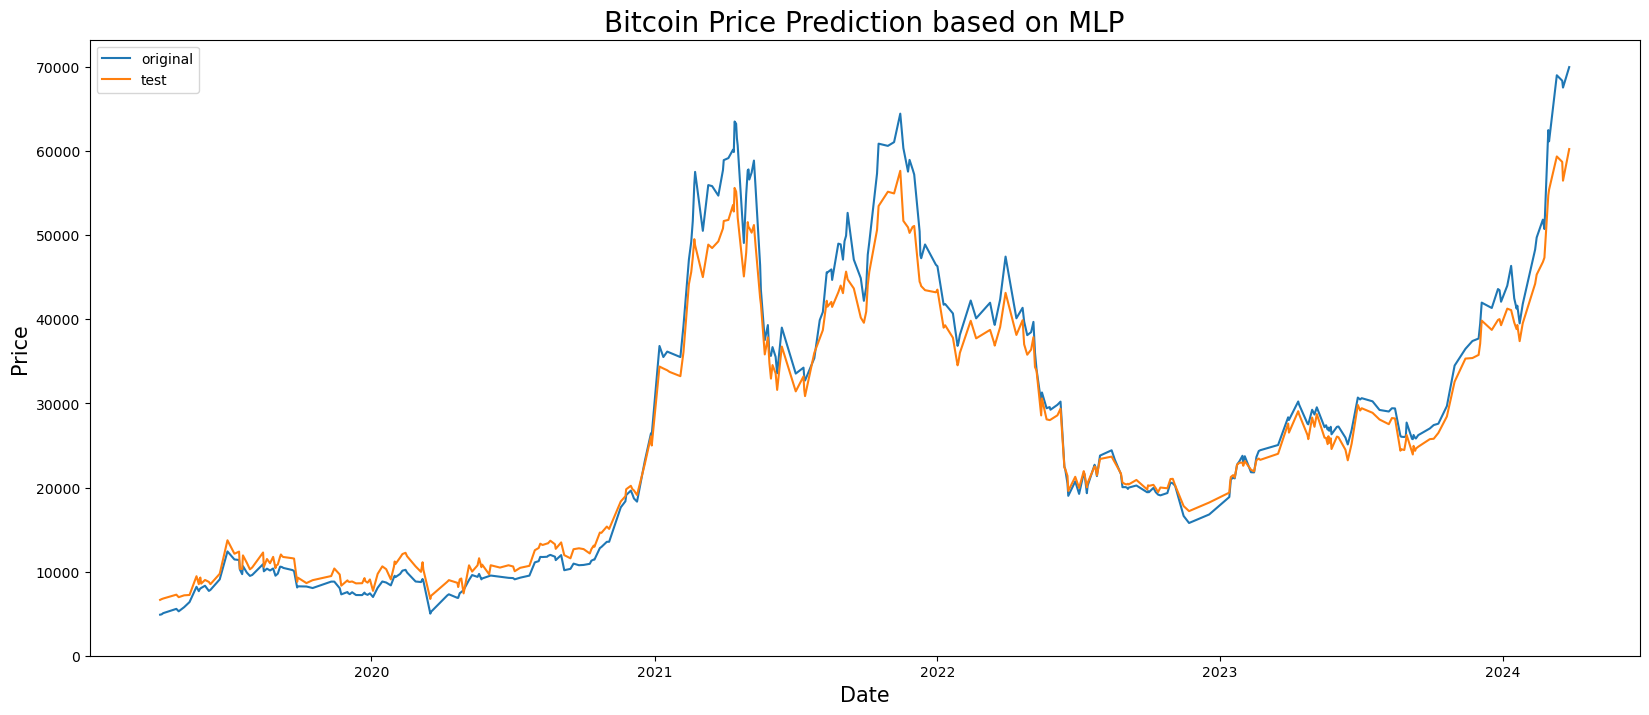

In [35]:
# np.delete(real_closing_prices, 201)
# np.delete(predicted_closing_prices,201)
# np.delete(np.array(y_test.index),201)

df_real = pd.DataFrame(dict(Date=np.delete(np.array(y_test.index),[314, 338, 201]), close=np.delete(real_closing_prices, [314, 338, 201])))
df_real = df_real.sort_values('Date')
df_real = df_real.reset_index(drop=True)

df_pred = pd.DataFrame(dict(Date=np.delete(np.array(y_test.index),[314, 338, 201]), close=np.delete(predicted_closing_prices, [314, 338, 201])))
df_pred = df_pred.sort_values('Date')
df_pred = df_pred.reset_index(drop=True)
df_real
fig = plt.figure(figsize=(20,8))
plt.plot(df_real['Date'], df_real['close'], label = 'Original')
plt.plot(df_pred['Date'], df_pred['close'], label = 'Predicted')
plt.legend()
plt.title('Bitcoin Price Prediction based on MLP', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.ylim(0) 

### Model 2 (128 ReLU, BN, 64 ReLU, Dropout)


In [21]:
tf.keras.utils.set_random_seed(4012)
model = Sequential()
model.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization(axis=-1, epsilon=1e-8))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 1.7121 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.4304
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.1690
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 0.1149
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.0802
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0527
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0443
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.0336
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0263
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0238
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.0230
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0240
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0186
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0200
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

In [22]:
predicted_prices = model.predict(X_test)
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, predicted_prices)
mse_value

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(), dtype=float32, numpy=1.6374483>

In [23]:
predicted_prices.shape

(366, 1)

In [24]:
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped[:, 0] = predicted_prices[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale = scaler.inverse_transform(predicted_prices_reshaped)

In [25]:
predicted_closing_prices = predicted_prices_original_scale[:, 0]
predicted_closing_prices

array([   19656.08032523,    44266.72681586,    13323.69421427,
          41798.11631702,     8786.18186815,    42075.29150126,
          39292.2956047 ,    42205.42241356,    47936.27218484,
          11115.10709207,    11589.25261527,    36022.95222786,
          45675.30051507,    38745.35767848,    11052.65017426,
          50902.00554454,    24850.43454597,    20375.12216944,
           8504.49261757,    26099.3632325 ,    41097.43702043,
          21599.99844697,    28447.57601763,    23234.72769179,
          18969.27726033,     9008.81413977,    40027.02773504,
           9077.09247646,    23396.48790221,    31597.73653196,
          13166.77901949,    24461.38821776,     8637.09228837,
          53603.25901766,    47335.16135143,    25474.29249143,
          54741.88086099,    27531.1835511 ,    43467.73296341,
          11742.50270064,    33240.82378849,    25752.84286255,
          19909.97086175,    51691.55192482,    10625.57550944,
          20582.0394879 ,    36764.68568

#### Plots 

In [26]:
# Reshape predicted_prices to match the expected shape
real_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
real_prices_reshaped[:, 0] = y_test  # Assuming the first column is the predicted closing price

# Apply inverse transformation
real_prices_original_scale = scaler.inverse_transform(real_prices_reshaped)
real_closing_prices = real_prices_original_scale[:, 0]

In [27]:
predicted_closing_prices[predicted_closing_prices <0]

array([-1640358.51179291])

In [28]:
# Find the indices where values are less than 0 (error)
# extreme negative data at index 201
np.nonzero(predicted_closing_prices < 0)

(array([201], dtype=int64),)

In [29]:
np.delete(real_closing_prices, 201)

array([18698.38477 , 47642.14453 , 11749.87109 , 43488.05859 ,
        8113.101074, 45936.45703 , 41819.50781 , 45599.70313 ,
       54858.08984 ,  9121.600586, 10183.64844 , 35384.03125 ,
       49937.85938 , 41974.07031 ,  9887.730469, 57825.86328 ,
       26228.27734 , 19969.71875 ,  7677.269043, 27118.42383 ,
       46354.79297 , 21591.08008 , 29683.38086 , 25121.67383 ,
       18365.01563 ,  8320.286133, 43468.19922 ,  8364.410156,
       23796.81836 , 33125.46875 , 11737.3252  , 26008.24219 ,
        8229.84082 , 60175.94531 , 50736.37109 , 26855.96094 ,
       62499.18359 , 29038.51367 , 48900.46484 , 10443.22852 ,
       35510.82031 , 27024.8418  , 19344.96484 , 58930.27734 ,
        8825.34375 , 20041.03516 , 39016.96875 , 47264.63281 ,
       40123.57031 , 49288.25    , 60360.13672 , 41815.625   ,
       21819.00586 , 26329.46094 , 11768.69727 ,  9084.233398,
        8825.09375 ,  8812.489258, 57714.66406 , 29892.74023 ,
       27218.41211 , 25748.3125  , 20211.4668  , 61068.

In [30]:
np.delete(predicted_closing_prices,201)

array([19656.08032523, 44266.72681586, 13323.69421427, 41798.11631702,
        8786.18186815, 42075.29150126, 39292.2956047 , 42205.42241356,
       47936.27218484, 11115.10709207, 11589.25261527, 36022.95222786,
       45675.30051507, 38745.35767848, 11052.65017426, 50902.00554454,
       24850.43454597, 20375.12216944,  8504.49261757, 26099.3632325 ,
       41097.43702043, 21599.99844697, 28447.57601763, 23234.72769179,
       18969.27726033,  9008.81413977, 40027.02773504,  9077.09247646,
       23396.48790221, 31597.73653196, 13166.77901949, 24461.38821776,
        8637.09228837, 53603.25901766, 47335.16135143, 25474.29249143,
       54741.88086099, 27531.1835511 , 43467.73296341, 11742.50270064,
       33240.82378849, 25752.84286255, 19909.97086175, 51691.55192482,
       10625.57550944, 20582.0394879 , 36764.6856833 , 43952.91698215,
       38143.25810831, 44621.17146892, 51706.28636357, 39530.61610686,
       22118.56106732, 24580.74374948, 13348.30163144, 10044.57447154,
      

In [31]:
np.delete(np.array(y_test.index),201)

array(['2020-12-05T00:00:00.000000000', '2021-12-10T00:00:00.000000000',
       '2020-08-06T00:00:00.000000000', '2021-05-18T00:00:00.000000000',
       '2019-09-27T00:00:00.000000000', '2021-08-17T00:00:00.000000000',
       '2022-01-11T00:00:00.000000000', '2021-08-11T00:00:00.000000000',
       '2021-04-29T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2019-09-21T00:00:00.000000000', '2021-07-26T00:00:00.000000000',
       '2021-09-05T00:00:00.000000000', '2022-03-10T00:00:00.000000000',
       '2019-07-24T00:00:00.000000000', '2021-05-02T00:00:00.000000000',
       '2023-09-14T00:00:00.000000000', '2022-09-03T00:00:00.000000000',
       '2019-05-23T00:00:00.000000000', '2023-05-21T00:00:00.000000000',
       '2024-01-12T00:00:00.000000000', '2022-07-10T00:00:00.000000000',
       '2023-10-21T00:00:00.000000000', '2023-06-15T00:00:00.000000000',
       '2020-11-24T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
       '2023-12-28T00:00:00.000000000', '2020-01-26

In [32]:
df_real = pd.DataFrame(dict(Date=np.delete(np.array(y_test.index),201), close=np.delete(real_closing_prices, 201)))
df_real = df_real.sort_values('Date')
df_real = df_real.reset_index(drop=True)

df_pred = pd.DataFrame(dict(Date=np.delete(np.array(y_test.index),201), close=np.delete(predicted_closing_prices, 201)))
df_pred = df_pred.sort_values('Date')
df_pred = df_pred.reset_index(drop=True)

In [33]:
df_real

,Date,close
0,2019-03-31,4105.456055
1,2019-04-03,4879.958008
2,2019-04-05,4922.806152
3,2019-04-07,5062.793945
4,2019-04-16,5066.577637
...,...,...
360,2024-03-01,61168.062500
361,2024-03-11,69020.546880
362,2024-03-18,68371.304690
363,2024-03-19,67556.132810


(0.0, 73286.22055925001)

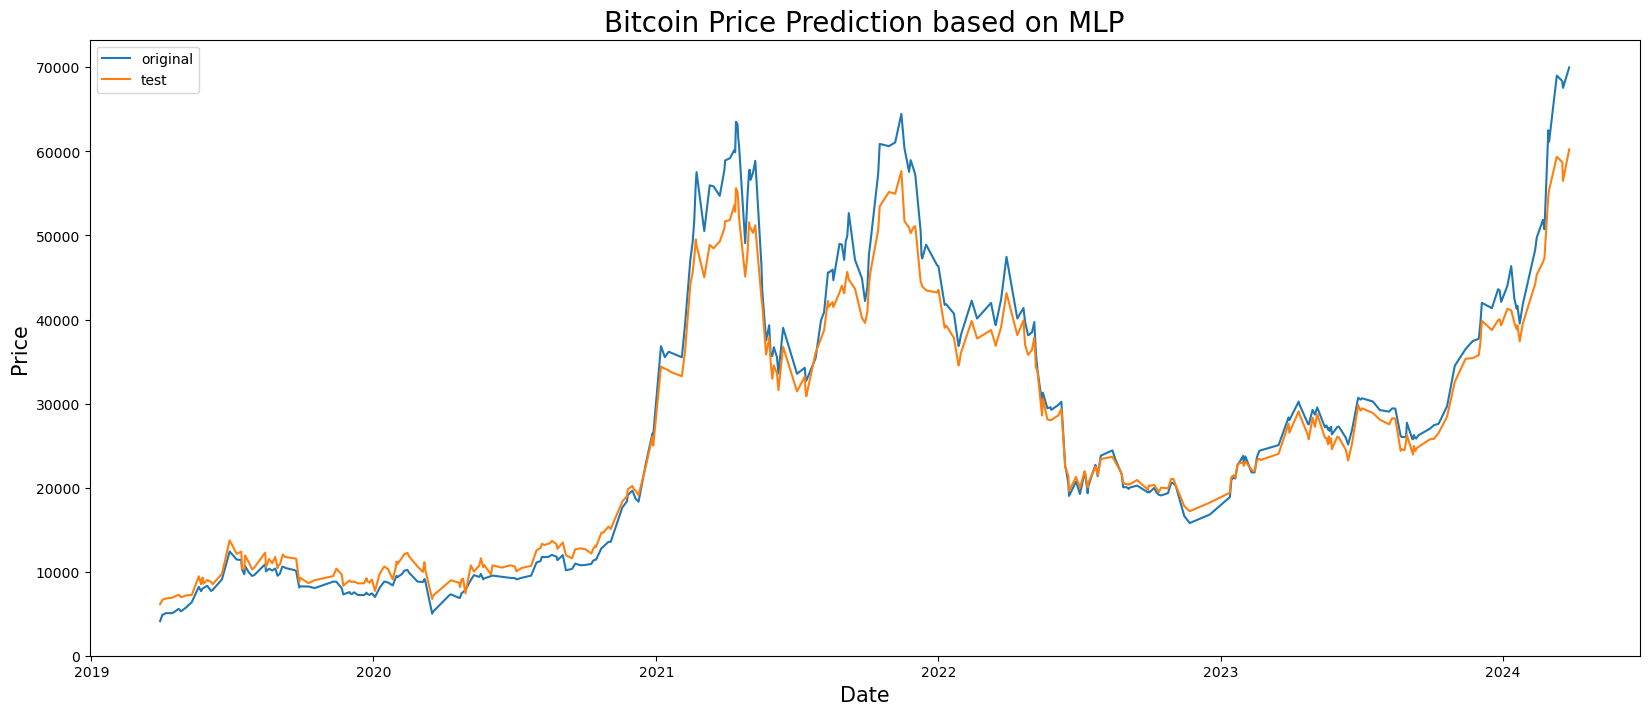

In [34]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_real['Date'], df_real['close'], label = 'original')
plt.plot(df_pred['Date'], df_pred['close'], label = 'test')
plt.legend()
plt.title('Bitcoin Price Prediction based on MLP', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.ylim(0)

### Model 3 (128 ReLU, BN, Dropout, 64 ReLU)
Test on Dropout Layer: 0.2, 0.5, 0.7

In [58]:
# Dropout 0.2
tf.keras.utils.set_random_seed(4012)
model1 = Sequential()
model1.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization(axis=-1, epsilon=1e-8))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1))

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model1.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 3.0545 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.2540
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 0.1695
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.1539
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.1270
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 0.1089
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.0929
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 0.0798
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0628
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0539
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0512
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0438
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0340 
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.0344
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [59]:
# Dropout 0.5
tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization(axis=-1, epsilon=1e-8))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 4.7688 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.8161
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.4845
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.3349
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 0.2622
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.2061
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.1546
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.1384
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.1323
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1095 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.1203
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0891
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.0947
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.0909
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [60]:
# Dropout 0.7
tf.keras.utils.set_random_seed(4012)
model3 = Sequential()
model3.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization(axis=-1, epsilon=1e-8))
model3.add(Dropout(0.7))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1))

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model3.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 7.0358  
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 1.3553
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.9113
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.5250
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.4277
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.3529
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.3089
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.3070
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.2745
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.2562
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.2522
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.2328
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.2447
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.2128
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0

In [67]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
predicted_prices1 = model1.predict(X_test)
predicted_prices2 = model2.predict(X_test)
predicted_prices3 = model3.predict(X_test)
mse_value1 = mse(y_test, predicted_prices1)
mse_value2 = mse(y_test, predicted_prices2)
mse_value3 = mse(y_test, predicted_prices3)
mae_value1 = mae(y_test, predicted_prices1)
mae_value2 = mae(y_test, predicted_prices2)
mae_value3 = mae(y_test, predicted_prices3)

dropout_df = pd.DataFrame(dict(Dropout=np.array([0.2,0.5,0.6])))
mse_arr = np.array([mse_value1, mse_value2, mse_value3])
dropout_df['MSE'] = mse_arr
mae_arr = np.array([mae_value1, mae_value2, mae_value3])
dropout_df['MAE'] = mae_arr
dropout_df

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


,Dropout,MSE,MAE
0,0.2,0.007300,0.052971
1,0.5,0.040275,0.075396
2,0.6,9.442571,0.211445


> Putting dropout layer directly after the batch normalization results a smaller MSE.

### Model 4 Change no of layers (1-5) with Dropout (0.5)
Test on No of Layers

In [101]:
# 3 64-nueron layers with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model1 = Sequential()
model1.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1))

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model1.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1239   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0145
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0092
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0052
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0047
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0041
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0037
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.0029
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0023
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0021
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0020
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0020
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8

In [85]:
# 4 64-nueron layers with 1 Dropout
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0443   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0075
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.0047
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0038
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0029
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0029
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0025
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0021
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0020
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0019
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.0018
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0017
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0014
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [86]:
# 5 64-nueron layers with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model3 = Sequential()
model3.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1))

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model3.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0971
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0041
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0029
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0020
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0020
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0016
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0014
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0013
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0012   
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 956u

In [87]:
# 2 64-nueron layers with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model4 = Sequential()
model4.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1))

model4.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model4.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3539   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0365
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0207
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0128
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0111
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0098
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0099
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0079
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0068
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0076
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0065
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0058
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0059
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0058
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

In [88]:
# 1 64-nueron layer with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model5 = Sequential()
model5.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1))

model5.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model5.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3149   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0795
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0487
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0400
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0319
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0274
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0246
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0208
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0185
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0156
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0154
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0110
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0121
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step -

In [95]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
predicted_prices1 = model1.predict(X_test)
predicted_prices2 = model2.predict(X_test)
predicted_prices3 = model3.predict(X_test)
predicted_prices4 = model4.predict(X_test)
predicted_prices5 = model5.predict(X_test)

mse_value1 = mse(y_test, predicted_prices1)
mse_value2 = mse(y_test, predicted_prices2)
mse_value3 = mse(y_test, predicted_prices3)
mse_value4 = mse(y_test, predicted_prices4)
mse_value5 = mse(y_test, predicted_prices5)

mae_value1 = mae(y_test, predicted_prices1)
mae_value2 = mae(y_test, predicted_prices2)
mae_value3 = mae(y_test, predicted_prices3)
mae_value4 = mae(y_test, predicted_prices4)
mae_value5 = mae(y_test, predicted_prices5)

layers_df = pd.DataFrame(dict(Layers=np.array([3,4,5,2,1])))
mse_arr = np.array([mse_value1, mse_value2, mse_value3, mse_value4, mse_value5])
layers_df['MSE'] = mse_arr
mae_arr = np.array([mae_value1, mae_value2, mae_value3, mae_value4, mae_value5])
layers_df['MAE'] = mae_arr
layers_df = layers_df.sort_values('Layers')
layers_df = layers_df.reset_index(drop=True)
layers_df

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


,Layers,MSE,MAE
0,1,0.000365,0.014755
1,2,0.015254,0.099259
2,3,0.033938,0.142421
3,4,0.029654,0.136019
4,5,0.037795,0.153982


#### Plots

In [103]:
# Reshape predicted_prices to match the expected shape
real_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
real_prices_reshaped[:, 0] = y_test  # Assuming the first column is the predicted closing price

# Apply inverse transformation
real_prices_original_scale = scaler.inverse_transform(real_prices_reshaped)
real_closing_prices = real_prices_original_scale[:, 0]

In [105]:
predicted_prices1 = model1.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped1 = np.zeros((predicted_prices1.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped1[:, 0] = predicted_prices1[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale1 = scaler.inverse_transform(predicted_prices_reshaped1)
predicted_closing_prices1 = predicted_prices_original_scale1[:, 0]

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


In [115]:
predicted_prices2 = model2.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped2 = np.zeros((predicted_prices2.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped2[:, 0] = predicted_prices2[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale2 = scaler.inverse_transform(predicted_prices_reshaped2)
predicted_closing_prices2 = predicted_prices_original_scale2[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [116]:
predicted_prices3 = model3.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped3 = np.zeros((predicted_prices3.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped3[:, 0] = predicted_prices3[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale3 = scaler.inverse_transform(predicted_prices_reshaped3)
predicted_closing_prices3 = predicted_prices_original_scale3[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [117]:
predicted_prices4 = model4.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped4 = np.zeros((predicted_prices4.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped4[:, 0] = predicted_prices4[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale4 = scaler.inverse_transform(predicted_prices_reshaped4)
predicted_closing_prices4 = predicted_prices_original_scale4[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [118]:
predicted_prices5 = model5.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped5 = np.zeros((predicted_prices5.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped5[:, 0] = predicted_prices5[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale5 = scaler.inverse_transform(predicted_prices_reshaped5)
predicted_closing_prices5 = predicted_prices_original_scale5[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [119]:
df_layers = pd.DataFrame(dict(Date=np.array(y_test.index), close_real=real_closing_prices))
df_layers['close_pred_1'] = predicted_closing_prices1
df_layers['close_pred_2'] = predicted_closing_prices2
df_layers['close_pred_3'] = predicted_closing_prices3
df_layers['close_pred_4'] = predicted_closing_prices4
df_layers['close_pred_5'] = predicted_closing_prices5
df_layers = df_layers.sort_values('Date')
df_layers = df_layers.reset_index(drop=True)
df_layers

,Date,close_real,close_pred_1,close_pred_2,close_pred_3,close_pred_4,close_pred_5
0,2019-03-31,4105.456055,5497.658334,5497.658334,5034.711321,10656.180098,5886.150168
1,2019-04-03,4879.958008,5894.955527,5894.955527,5479.883813,10748.969753,6106.656964
2,2019-04-05,4922.806152,5827.458313,5827.458313,5414.622434,10734.010742,5965.781505
3,2019-04-07,5062.793945,5876.143834,5876.143834,5494.308886,10756.532767,5995.740640
4,2019-04-16,5066.577637,5829.151730,5829.151730,5470.614277,10741.273640,5842.846171
...,...,...,...,...,...,...,...
361,2024-03-01,61168.062500,35648.819174,35648.819174,37367.175815,43173.738976,59550.368745
362,2024-03-11,69020.546880,39986.031133,39986.031133,41936.884801,47953.407548,67580.905088
363,2024-03-18,68371.304690,38903.308888,38903.308888,40949.048395,46869.028502,65304.512414
364,2024-03-19,67556.132810,37978.809192,37978.809192,40306.118725,45447.488167,63781.903039


(0.0, 73286.22055925001)

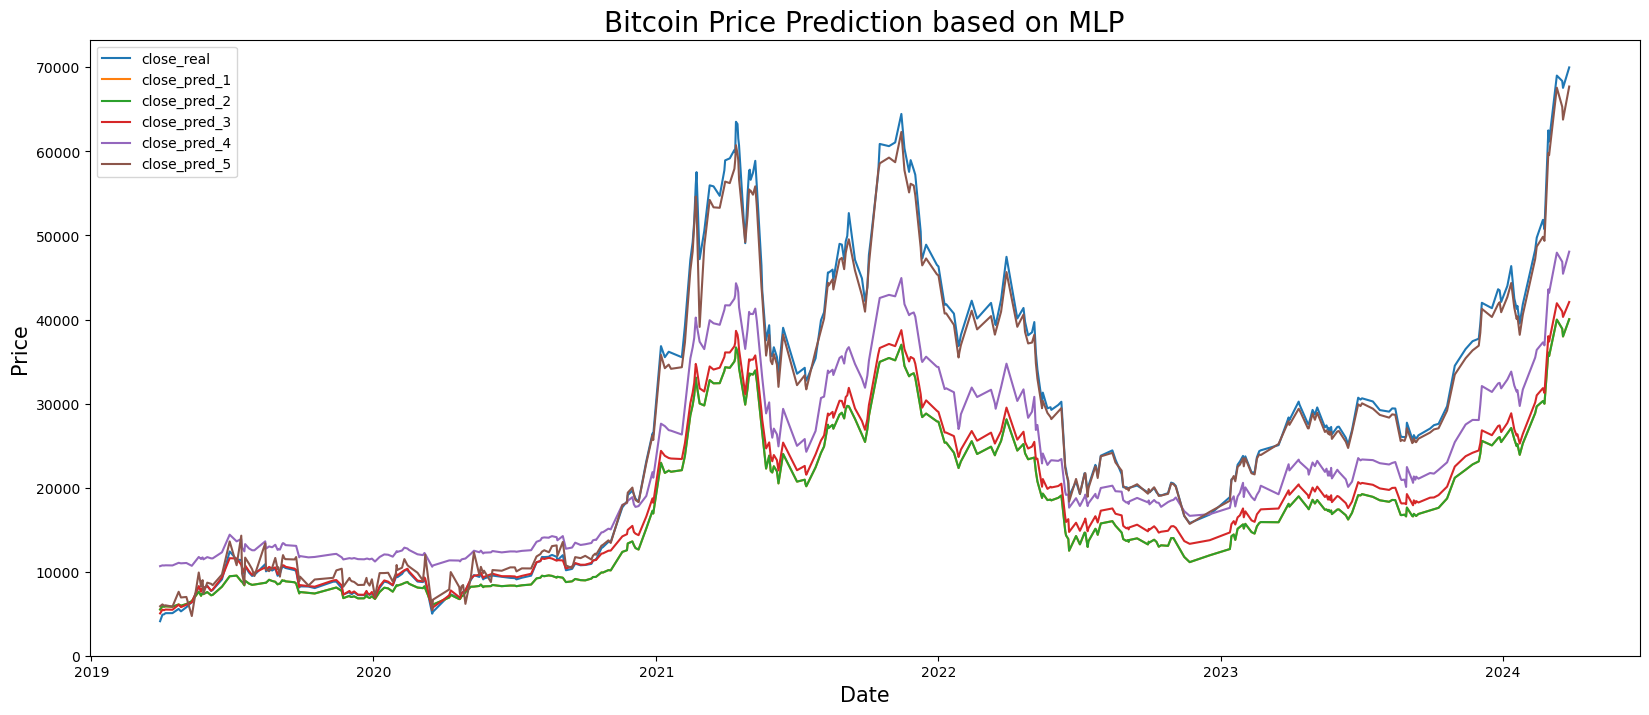

In [131]:
fig = plt.figure(figsize=(20,8))
for i in range(df_layers.shape[1]-1):
    col = df_layers.columns[i+1]
    plt.plot(df_layers['Date'], df_layers[col], label = col)
plt.legend()
plt.title('Bitcoin Price Prediction based on MLP', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.ylim(0)

### Model 5 Change no of neurons (32,64,128) with 3 layers and 1 Dropout (0.5)

In [139]:
# 1 32-nueron layer with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model1 = Sequential()
model1.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model1.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - loss: 0.5550 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.2495
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.1113
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0904
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0748
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0615
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0545
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0509
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0429
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0366
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0322
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0314
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0334
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0287 
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step -

In [140]:
# 1 64-nueron layer with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.3149 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.0795
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.0487
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.0400
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0319
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.0274
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0246
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0208
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0185
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0156
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0154
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 0.0151
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0110
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0121
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

In [141]:
# 1 128-nueron layer with 1 Dropout
tf.keras.utils.set_random_seed(4012)
model3 = Sequential()
model3.add(tf.keras.Input(shape=(X_train.shape[1],))) #input features
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1))

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model3.fit(X_train, y_train, batch_size=128, epochs=100, shuffle=True)

Epoch 1/100


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1642  
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0421
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0306
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0203
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0187
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0161
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0147
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0126
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0131
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0130
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0104
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0101
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0092
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.0092
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step 

In [142]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
predicted_prices1 = model1.predict(X_test)
predicted_prices2 = model2.predict(X_test)
predicted_prices3 = model3.predict(X_test)

mse_value1 = mse(y_test, predicted_prices1)
mse_value2 = mse(y_test, predicted_prices2)
mse_value3 = mse(y_test, predicted_prices3)

mae_value1 = mae(y_test, predicted_prices1)
mae_value2 = mae(y_test, predicted_prices2)
mae_value3 = mae(y_test, predicted_prices3)

layers_df = pd.DataFrame(dict(Neurons=np.array([32,64,128])))
mse_arr = np.array([mse_value1, mse_value2, mse_value3])
layers_df['MSE'] = mse_arr
mae_arr = np.array([mae_value1, mae_value2, mae_value3])
layers_df['MAE'] = mae_arr
layers_df = layers_df.sort_values('Neurons')
layers_df = layers_df.reset_index(drop=True)
layers_df

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Neurons,MSE,MAE
0,32,0.000800,0.023391
1,64,0.000365,0.014755
2,128,0.000087,0.005706


#### Plots

In [143]:
# Reshape predicted_prices to match the expected shape
real_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
real_prices_reshaped[:, 0] = y_test  # Assuming the first column is the predicted closing price

# Apply inverse transformation
real_prices_original_scale = scaler.inverse_transform(real_prices_reshaped)
real_closing_prices = real_prices_original_scale[:, 0]
predicted_prices1 = model1.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped1 = np.zeros((predicted_prices1.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped1[:, 0] = predicted_prices1[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale1 = scaler.inverse_transform(predicted_prices_reshaped1)
predicted_closing_prices1 = predicted_prices_original_scale1[:, 0]
predicted_prices2 = model2.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped2 = np.zeros((predicted_prices2.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped2[:, 0] = predicted_prices2[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale2 = scaler.inverse_transform(predicted_prices_reshaped2)
predicted_closing_prices2 = predicted_prices_original_scale2[:, 0]
predicted_prices3 = model3.predict(X_test)
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped3 = np.zeros((predicted_prices3.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped3[:, 0] = predicted_prices3[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale3 = scaler.inverse_transform(predicted_prices_reshaped3)
predicted_closing_prices3 = predicted_prices_original_scale3[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


In [144]:
df_layers = pd.DataFrame(dict(Date=np.array(y_test.index), close_real=real_closing_prices))
df_layers['close_pred_1'] = predicted_closing_prices1
df_layers['close_pred_2'] = predicted_closing_prices2
df_layers['close_pred_3'] = predicted_closing_prices3
df_layers = df_layers.sort_values('Date')
df_layers = df_layers.reset_index(drop=True)
df_layers

,Date,close_real,close_pred_1,close_pred_2,close_pred_3
0,2019-03-31,4105.456055,7889.729611,5886.150168,5513.806502
1,2019-04-03,4879.958008,8009.923822,6106.656964,5825.131133
2,2019-04-05,4922.806152,7860.512543,5965.781505,5769.508010
3,2019-04-07,5062.793945,7855.021046,5995.740640,5832.330822
4,2019-04-16,5066.577637,7657.040386,5842.846171,5772.886365
...,...,...,...,...,...
361,2024-03-01,61168.062500,59142.947535,59550.368745,61206.915977
362,2024-03-11,69020.546880,67152.364791,67580.905088,69246.488675
363,2024-03-18,68371.304690,64651.300704,65304.512414,67246.407839
364,2024-03-19,67556.132810,61937.047706,63781.903039,65100.791531


(0.0, 73286.22055925001)

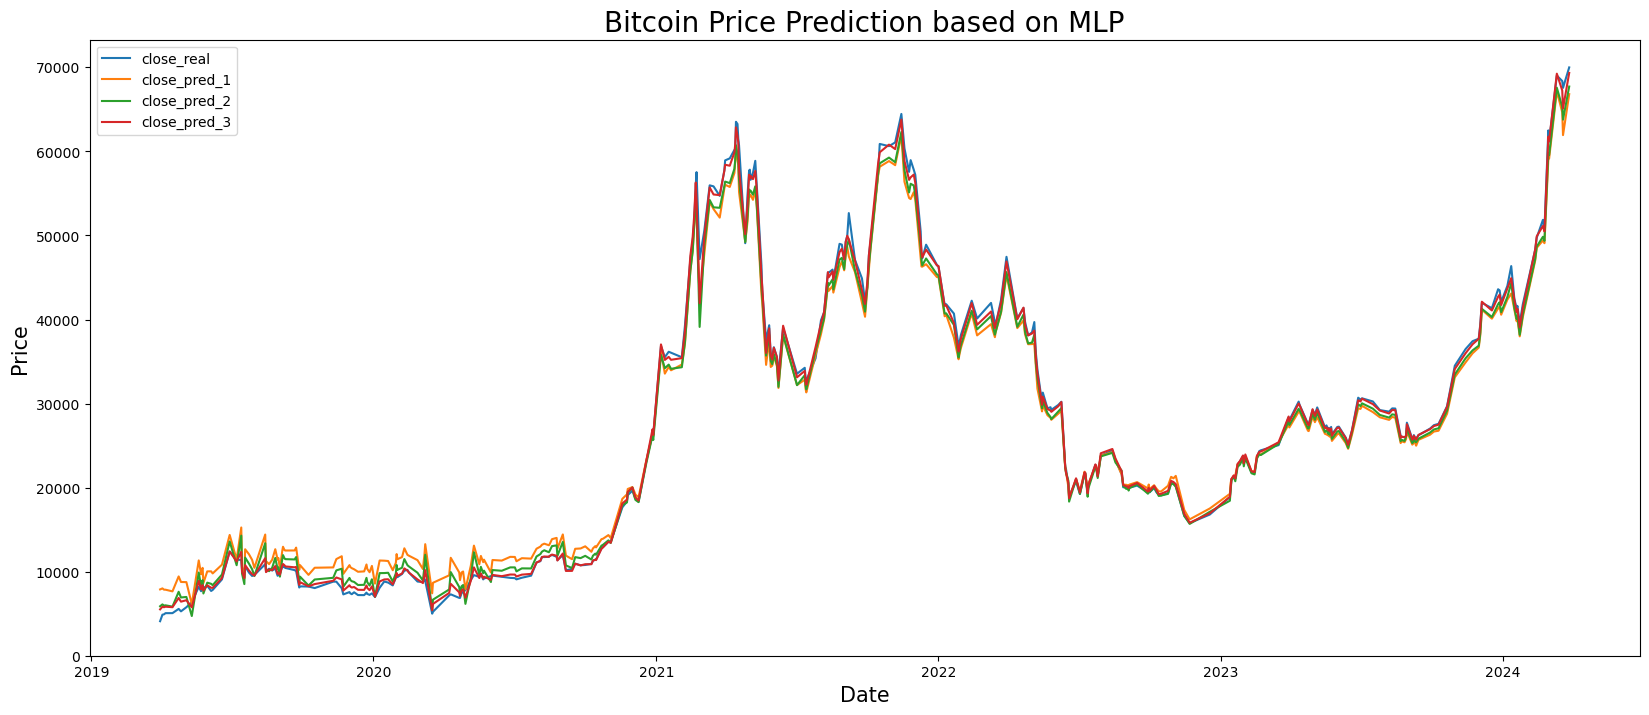

In [145]:
fig = plt.figure(figsize=(20,8))
for i in range(df_layers.shape[1]-1):
    col = df_layers.columns[i+1]
    plt.plot(df_layers['Date'], df_layers[col], label = col)
plt.legend()
plt.title('Bitcoin Price Prediction based on MLP', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.ylim(0)